In [13]:
import numpy as np
import dill
import importlib
import os
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import numba as nb
import time
'''
v4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3

As of 1/13/23, the only change is the addition of the decision to action delay
'''

'\nv4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3\n\nAs of 1/13/23, the only change is the addition of the decision to action delay\n'

In [14]:
experiment = 'Exp1'

# Select Exp1 or Exp2


In [15]:
experiment = "Exp1"

In [16]:
import read_data_functions as rdf
import plot_functions as pf
import Optimal_Stopping_Object
importlib.reload(Optimal_Stopping_Object)
import Optimal_Stopping_Object as oso
import Subject_Object_v2

# Initial Thangs


In [17]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
PATH = os.getcwd()
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH + "\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH + "\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == "Exp2":
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Payoff Condition"
if experiment == "Exp1":
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = "1100 (50)"
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = "1200 (150)"
    trial_block_titles = [tp3_title, tp4_title, tp5_title, tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = "Mean [SD] Agent Decision Time (ms)"
num_subjects

20

# Pickle Data


In [18]:
if "subject_objects" not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    subject_objects2 = copy.deepcopy(subject_objects)
    # group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2,
    #                                     task_leave_time_metric_name = 'player_pos_task_leave_time', task_movement_time_metric_name = 'player_pos_task_movement_time',
    #                                     reaction_time_metric_name = 'player_pos_reaction_time', reaction_movement_time_metric_name = 'player_pos_reaction_movement_time')
    # group.analyze_data()
    group = Subject_Object_v2.Group(
        subject_objects2,
        select_trials="All Trials",
        num_stds_for_reaction_time=2,
        task_leave_time_metric_name="player_velocity_task_leave_time_thresh",
        task_movement_time_metric_name="player_velocity_task_movement_time_thresh",
        reaction_time_metric_name="player_velocity_reaction_time_thresh",
        reaction_movement_time_metric_name="player_velocity_reaction_movement_time_thresh",
    )
    group.analyze_data()

In [19]:
# from pyheat import PyHeat
# # os.chdir(os.getcwd())
# ph = PyHeat('D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Optimal_Stopping_Object.py')
# ph.create_heatmap()

# Generate Models

In [35]:
if experiment == "Exp1":
    rt = np.nanmedian(group.reaction_time, axis=1) - 15
    rt_sd = np.nanstd(group.reaction_time, axis=1)
elif experiment == "Exp2":
    rt = np.nanmedian(group.react_reaction_time_only_react, axis=1) - 30
    rt_sd = np.nanmedian(np.nanstd(group.reaction_time, axis=2))

mt = np.min(np.nanmedian(group.player_task_movement_time, axis=2), axis=1)  # Get movement time for the condition where they tried the hardest
mt_sd = np.median(np.nanstd(group.player_task_movement_time, axis=2), axis=1)
time_sd = np.array([(np.nanstd(group.coincidence_reach_time, axis=1))] * num_blocks).T
perc_wins_both_reach = group.perc_gamble_wins_when_both_decide
gamble_sd = np.nanstd(group.player_gamble_task_leave_time, axis=2)
agent_sds = np.nanstd(group.agent_task_leave_time, axis=2)
agent_means = np.nanmean(group.agent_task_leave_time, axis=2)

model_expected_list = {}
model_true_list = {}
for i in range(num_subjects):
    subname = figures_pull_list[i]
    model_expected = oso.ModelConstructor(
        experiment=experiment,
        num_blocks=num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means[i, :],
        agent_sds=agent_sds[i, :],
        reaction_time={"true": rt[i], "exp": rt[i]},
        movement_time={"true": mt[i], "exp": mt[i]},
        reaction_sd={"true": rt_sd[i], "exp": rt_sd[i]},
        movement_sd={"true": mt_sd[i], "exp": mt_sd[i]},
        timing_sd={"true": time_sd[i], "exp": time_sd[i]},
        perc_wins_when_both_reach=perc_wins_both_reach[i],
        gamble_delay_known=True,
        gamble_sd_known=True,
        gamble_decision_sd={"true": gamble_sd[i], "exp": 10},
        gamble_delay={"true": 125, "exp": 50},
        expected=True,
    )

    model_true = oso.ModelConstructor(
        experiment=experiment,
        num_blocks=num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means[i, :],
        agent_sds=agent_sds[i, :],
        reaction_time={"true": rt[i], "exp": rt[i]},
        movement_time={"true": mt[i], "exp": mt[i]},
        reaction_sd={"true": rt_sd[i], "exp": rt_sd[i]},
        movement_sd={"true": mt_sd[i], "exp": mt_sd[i]},
        timing_sd={"true": time_sd[i], "exp": time_sd[i]},
        perc_wins_when_both_reach=perc_wins_both_reach[i],
        gamble_delay_known=True,
        gamble_sd_known=True,
        gamble_decision_sd={"true": gamble_sd[i], "exp": 10},
        gamble_delay={"true": 125, "exp": 50},
        expected=False,
    )
    # Fit true model
    model_true.fit_model(
        model_true.player_behavior.wtd_leave_target_time,
        np.nanmedian(group.player_task_leave_time, axis=2)[i],
    )
    # Fit expected model
    model_expected.fit_model(
        model_expected.player_behavior.wtd_leave_target_time,
        np.nanmedian(group.player_task_leave_time, axis=2)[i],
    )
    # Update dicts
    model_true_list.update({subname: model_true})
    model_expected_list.update({subname: model_expected})

# Put Individual Models into One Object for easy plotting

In [36]:
true_models = oso.Group_Models(model_true_list,num_blocks,model_true.inputs.num_timesteps,)

In [39]:
true_models.fit_decision_index

array([[ 986, 1062, 1048,  980,  977, 1080],
       [1217, 1156, 1139, 1080, 1144, 1142],
       [1148, 1096, 1124, 1014, 1104, 1048],
       [ 869,  900,  853,  946,  901, 1004],
       [1053, 1377, 1122, 1098, 1107, 1068],
       [ 970,  935,  986, 1145, 1039,  910],
       [1212, 1164, 1165, 1226, 1229, 1099],
       [1012, 1035, 1082,  936, 1043,  880],
       [1086, 1160, 1143, 1209, 1145, 1170],
       [1124, 1146, 1173, 1128, 1067, 1088],
       [ 975, 1066,  964, 1047, 1038,  914],
       [1230, 1189, 1097, 1114, 1062, 1080],
       [ 669,  489, 1226,  786,  819,  503],
       [1105, 1118, 1122, 1087, 1062, 1067],
       [ 997,  977, 1068, 1062, 1124, 1023],
       [1216, 1237, 1043, 1186, 1089, 1077],
       [1032, 1113, 1033, 1055, 1085, 1089],
       [1018, 1077, 1065, 1071, 1034,  967],
       [1092, 1084, 1141, 1139, 1163, 1140],
       [ 949,  781,  904,  869,  876,  708]])

In [40]:
true_models.get('player_behavior','wtd_leave_target_time',metric_type='fit')

array([[1149.74116628, 1166.6313222 , 1214.70084398, 1119.94339326,
        1112.53154224, 1219.8670685 ],
       [1229.80271283, 1211.54516661, 1307.31862184, 1216.04676693,
        1299.41229109, 1278.56919568],
       [1251.44586166, 1194.7673101 , 1298.19212615, 1169.25159233,
        1273.4384312 , 1199.66513269],
       [1008.20241051, 1041.83465513,  978.94039123, 1085.17851746,
        1026.22917955, 1139.34933926],
       [1236.7498372 , 1261.00225096, 1308.28596431, 1240.07305122,
        1245.01174736, 1204.3230053 ],
       [1133.1446317 , 1073.05554562, 1121.10608944, 1258.72654073,
        1166.49764183, 1037.84819558],
       [1235.90203388, 1243.80648945, 1319.42816916, 1300.07968277,
        1395.36462534, 1238.03777088],
       [1191.45721404, 1167.7511906 , 1266.67580011, 1090.41828515,
        1202.97086247, 1019.83944407],
       [1228.83738933, 1226.57290277, 1309.22864238, 1295.61173241,
        1311.80021916, 1305.82927532],
       [1253.06429762, 1214.04928032,

In [24]:
optimal_models = Group_Subject_Models_Object.Group_Subjects()
sub_models_expected = Group_Subject_Models_Object.Group_Subjects()
sub_models_true = Group_Subject_Models_Object.Group_Subjects()

NameError: name 'Group_Subject_Models_Object' is not defined

In [ ]:

if 'run_model_dict_fit' not in globals():
    # permission = input('Are you sure? Select "y" to fit the individual models: ?')
    # if permission == 'y':
        fit_model_dict = {}
        c=-1
        for k,v in optimal_model_dict.items():
            c+=1
            print(k)
            data_wins                = group.objects[c].player_perc_wins
            data_indecisions         = group.objects[c].player_perc_indecisions
            data_incorrects          = group.objects[c].player_perc_incorrects
            data_leave_target_time   = np.nanmedian(group.objects[c].player_task_leave_time,axis=1)
            data_reaction_decisions  = group.objects[c].perc_reaction_decisions
            data_gamble_decisions    = group.objects[c].perc_gamble_decisions
            data_reaction_leave_time = np.nanmedian(group.objects[c].player_reaction_task_leave_time,axis=1)
            data_gamble_leave_time   = np.nanmedian(group.objects[c].player_gamble_task_leave_time,axis=1)
            tune_data = [data_wins,data_indecisions,data_incorrects,data_leave_target_time,
                        data_reaction_decisions,data_gamble_decisions,data_reaction_leave_time,
                        data_gamble_leave_time]
            v.run_model()
            v.fit_model_to_data(tune_data)
            v.calculate_metrics_with_certain_decision_time(v.fit_decision_times_dict['Leave Target Time'])
            fit_model_dict.update({k:v})

c:\Users\Seth Sullivan\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Sub1
Sub2
Sub3
Sub4
Sub5
Sub6
Sub7
Sub8
Sub9
Sub10
Sub11
Sub12
Sub13
Sub14
Sub15
Sub16
Sub17
Sub18
Sub19
Sub20


Select metrci I want to fit to 

In [ ]:
for k,v in fit_model_dict.items():
    v.calculate_metrics_with_certain_decision_time(v.fit_decision_times_dict['Leave Target Time'])
    
grouped_model_tuned = Group_Subject_Models_Object.Group_Subjects([x for x in fit_model_dict.values()])

In [ ]:
grouped_model_tuned.movement_time

array([181.5, 128.5, 138.5, 265.5, 131. , 179.5, 152. , 139. , 129. ,
       131.5, 226. , 147. , 239.5, 180.5, 144. , 161. , 119. , 213.5,
       114.5, 314. ])

# Plots

In [ ]:
save = False

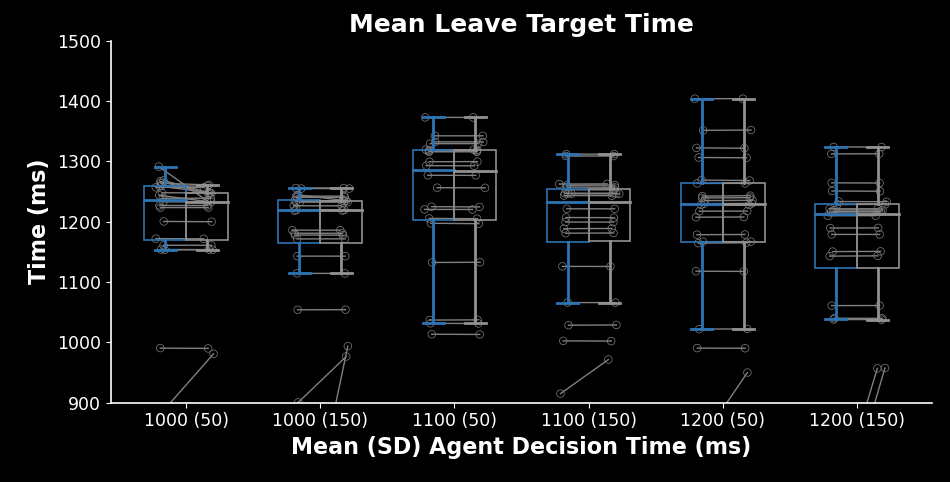

In [ ]:
metric = np.nanmedian(group.combine_all_subjects('player_task_leave_time'),axis=2) 
optimal_metric = grouped_model_tuned.wtd_optimal_leave_target_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/2,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

multi_boxplot(ax,optimal_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/2,data_list=optimal_metric.T, noise_scale=0.01, include_mean = False, circle_size=30)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],optimal_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Mean Leave Target Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

Player Minus Agent Mean Leave Target Time

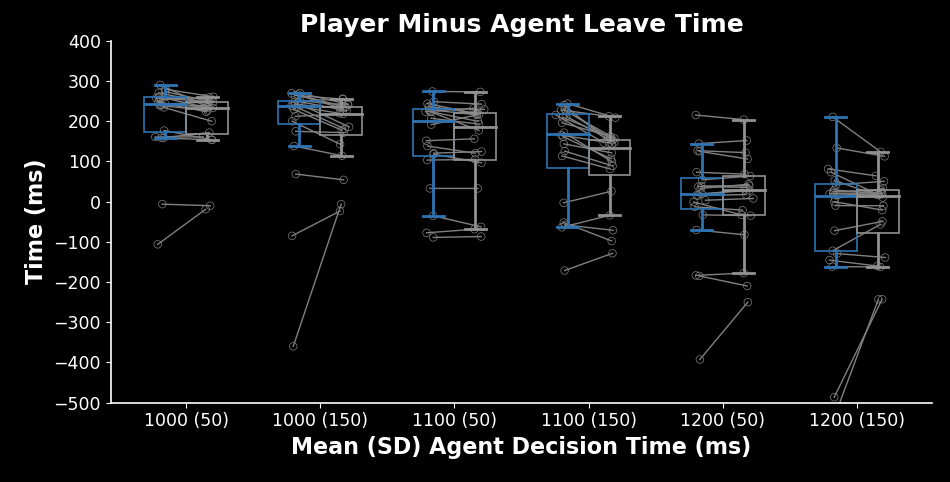

In [ ]:
metric = np.nanmedian(group.combine_all_subjects('player_minus_agent_task_leave_time'),axis=2) 
optimal_metric = grouped_model_tuned.player_minus_agent_leave_time

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(-500,500,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/2,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

multi_boxplot(ax,optimal_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/2,data_list=optimal_metric.T, noise_scale=0.01, include_mean = False, circle_size=30)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],optimal_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Player Minus Agent Leave Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

Wins

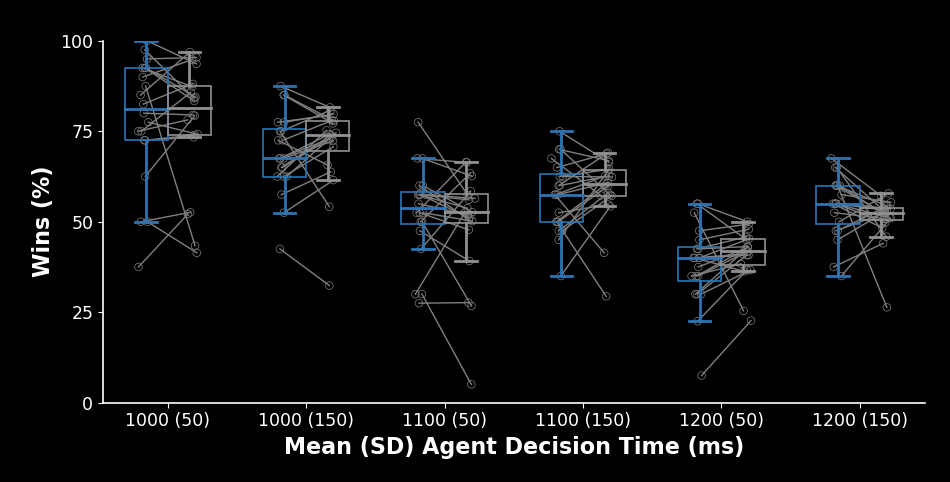

In [ ]:
metric = group.combine_all_subjects('player_perc_wins') 
optimal_metric = grouped.perc_win_optimal_calc
tuned_metric = grouped_model_tuned.perc_win_optimal_calc

# optimal_metric = group_model.prob_indecision_based_on_reach_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
# multi_boxplot(ax,optimal_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
multi_boxplot(ax,tuned_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],tuned_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        # dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],optimal_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Wins (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions

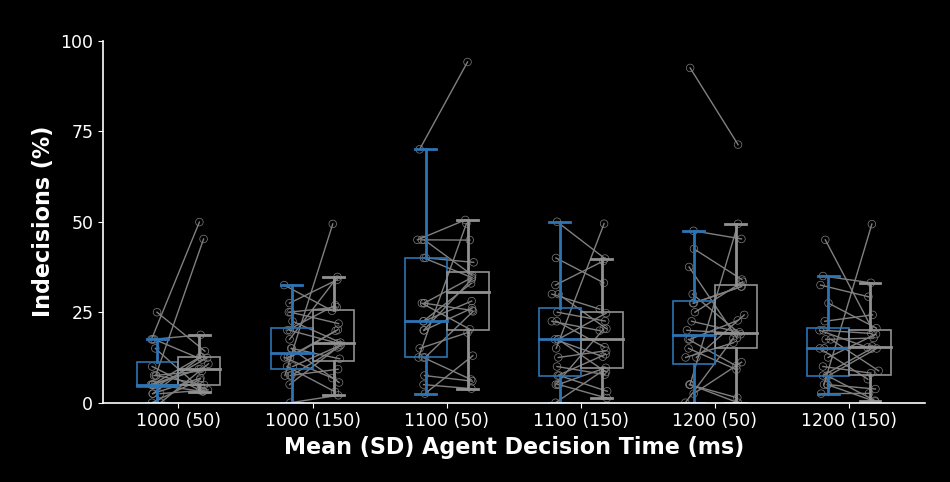

In [ ]:
metric = group.combine_all_subjects('player_perc_indecisions') 
optimal_metric = grouped.perc_indecision_optimal_calc
tuned_metric = grouped_model_tuned.perc_indecision_optimal_calc

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw/2,box_width = bw,colors = wheel.seth_blue)
# multi_boxplot(ax,optimal_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
multi_boxplot(ax,tuned_metric,xlocs=xlocs+bw/2,box_width = bw,colors = wheel.grey)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw/1.75,bw/1.75])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],tuned_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Indecisions (%)')
if save:
    plt.savefig(SAVE_PATH+'indecisions', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Incorrects

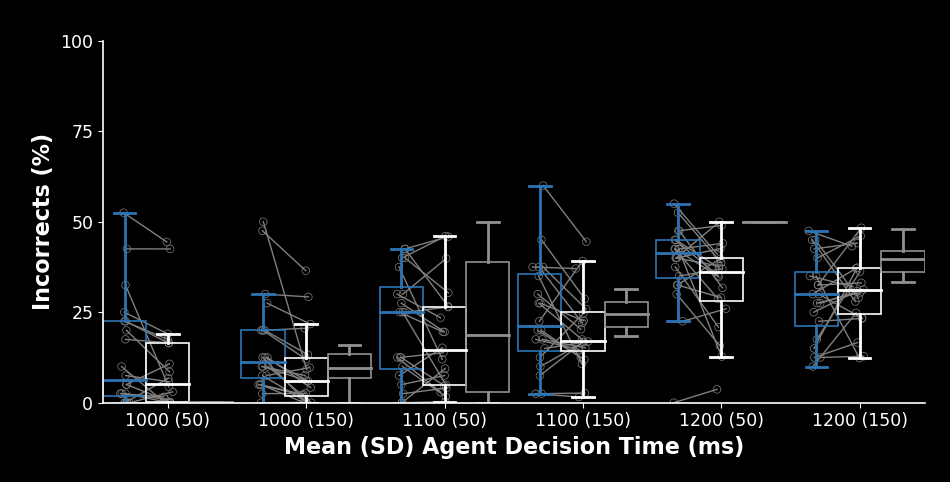

In [ ]:
metric = group.combine_all_subjects('player_perc_incorrects') 
optimal_metric = grouped.perc_incorrect_optimal_calc
tuned_metric = grouped_model_tuned.perc_incorrect_optimal_calc

# optimal_metric = group_model.prob_indecision_based_on_reach_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs-bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,tuned_metric,xlocs=xlocs,box_width = bw,colors = wheel.white)
multi_boxplot(ax,optimal_metric,xlocs=xlocs+bw,box_width = bw,colors = wheel.grey)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/2,data_list=optimal_metric.T, noise_scale=0.01, include_mean = False, circle_size=30)
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-bw,0])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric[:,j],tuned_metric[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_ylabel('Incorrects (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Gamble Decisions

In [ ]:

data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')
optimal_metric1 = grouped.perc_reaction_decisions_optimal*100
optimal_metric2 = grouped.perc_gamble_decisions_optimal*100
# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 13,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.33
multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction and Gamble Decisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

AttributeError: 'Group_Subjects' object has no attribute 'perc_reaction_decisions_optimal'

Reaction and Gamble Leave Times

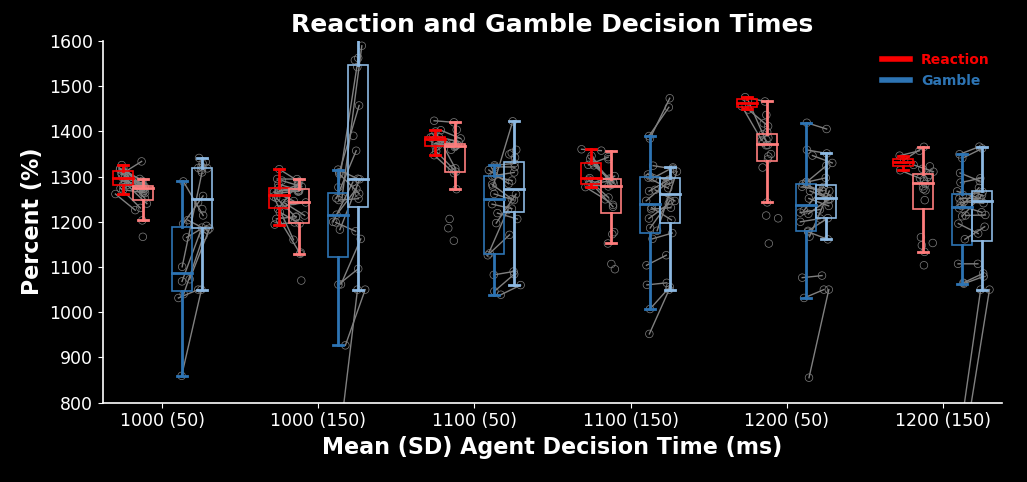

In [ ]:

data_metric1 = group.combine_all_subjects('player_reaction_leave_time_mean')
data_metric2 = group.combine_all_subjects('player_gamble_leave_time_mean')
optimal_metric1 = grouped.combine_all_subjects('optimal_reaction_leave_target_time')
optimal_metric2 = grouped.combine_all_subjects('optimal_gamble_leave_target_time')
# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 13,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(800,1700,100)


bw = 0.33
multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction and Gamble Decision Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Percent Indecisions That Were Gambles

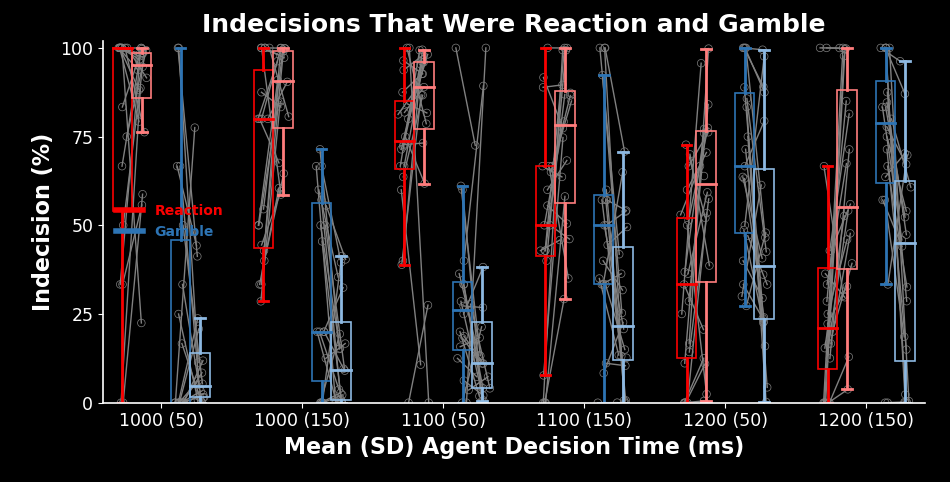

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
data_metric1 = group.combine_all_subjects('perc_indecisions_that_were_reactions') 
data_metric2 = group.combine_all_subjects('perc_indecisions_that_were_gambles') 
optimal_metric1 = grouped.combine_all_subjects('perc_indecisions_that_were_reaction')
optimal_metric2 = grouped.combine_all_subjects('perc_indecisions_that_were_gamble')
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.33
multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Indecision (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Indecisions That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'reaction_and_gamble_indecisions', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Wins That were reaction and gamble

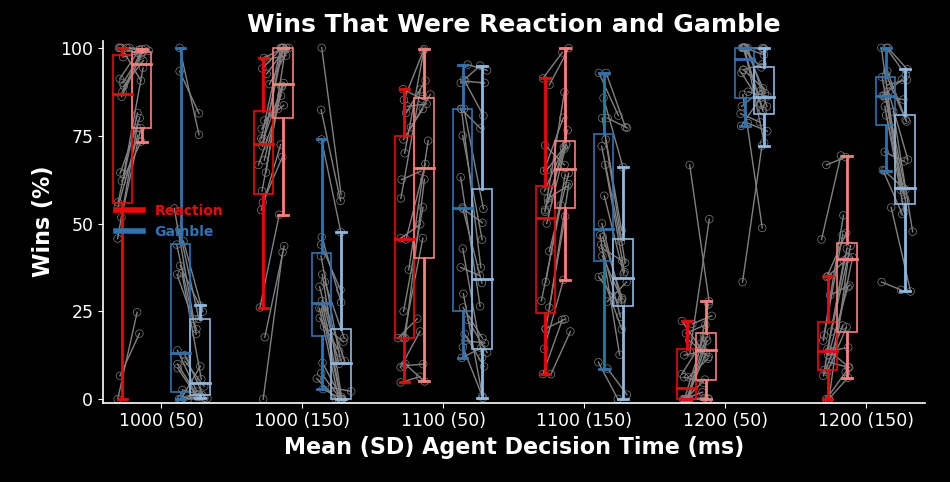

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
data_metric1 = group.combine_all_subjects('perc_wins_that_were_reactions') 
data_metric2 = group.combine_all_subjects('perc_wins_that_were_gambles') 
optimal_metric1 = grouped.combine_all_subjects('perc_wins_that_were_reaction')
optimal_metric2 = grouped.combine_all_subjects('perc_wins_that_were_gamble')

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)
bw = 0.33
multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Wins That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Incorrects that were reaction and gamble

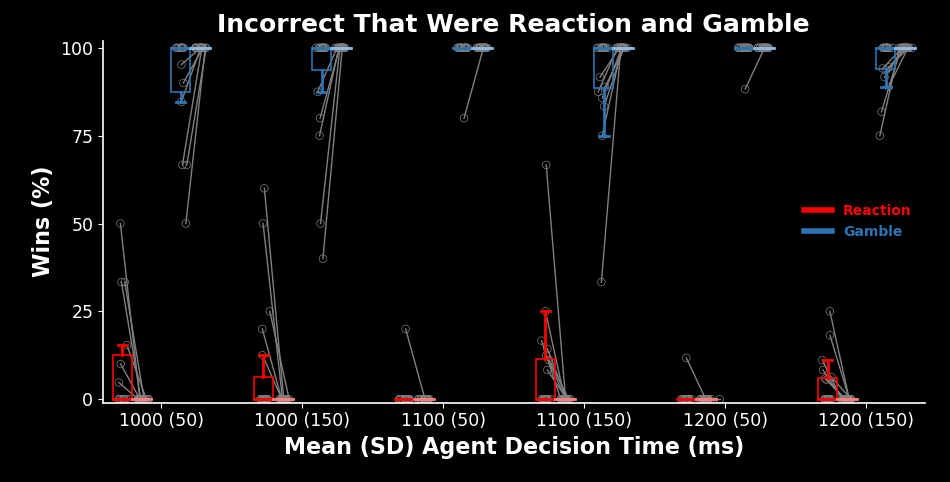

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
data_metric1 = group.combine_all_subjects('perc_incorrects_that_were_reactions') 
data_metric2 = group.combine_all_subjects('perc_incorrects_that_were_gambles') 
optimal_metric1 = grouped.combine_all_subjects('perc_incorrects_that_were_reaction')
optimal_metric2 = grouped.combine_all_subjects('perc_incorrects_that_were_gamble')

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)
bw = 0.33
multi_boxplot(ax,data_metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[data_metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Incorrect That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'incorrects_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/Gamble How many times did they win (not done)

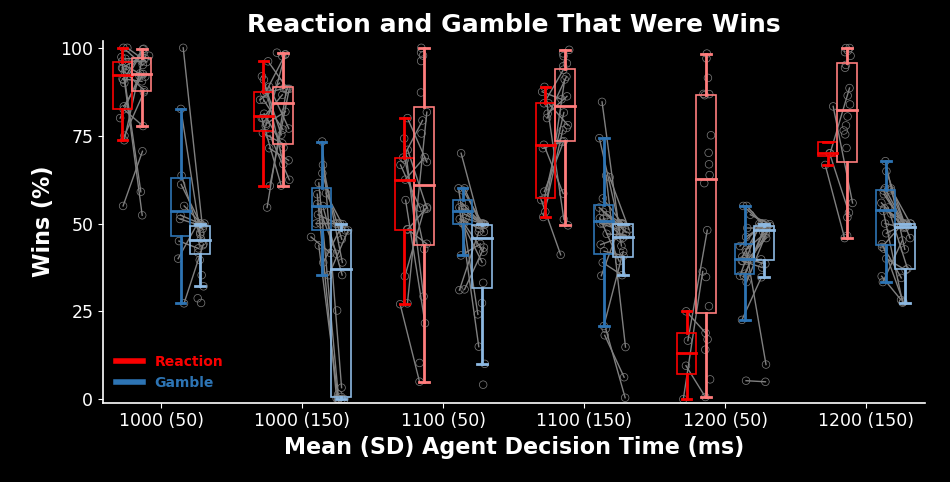

In [ ]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_reactions_that_were_wins') 
metric2 = group.combine_all_subjects('perc_gambles_that_were_wins') 
optimal_metric1 = grouped.combine_all_subjects('perc_reactions_that_were_wins')
optimal_metric2 = grouped.combine_all_subjects('perc_gambles_that_were_wins')

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)
bw = 0.33
multi_boxplot(ax,metric1,xlocs=xlocs-(2*bw),box_width = bw,colors = wheel.seth_red)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.lighten_color(wheel.seth_red,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([-2*bw,-bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric1[:,j],optimal_metric1[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)
        
multi_boxplot(ax,metric2,xlocs=xlocs+bw,box_width = bw,colors = wheel.seth_blue)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+(2*bw),box_width = bw,colors = wheel.lighten_color(wheel.seth_blue,0.5))
for j in range(num_blocks):     
        m = np.array([xlocs[j],xlocs[j]])
        x_pos = m + np.array([bw,2*bw])
        dv.jitter_array(ax=ax,x_positions=x_pos,data_list=[metric2[:,j],optimal_metric2[:,j]], noise_scale=0.05, include_mean = False, circle_size=30, linewidth = 1)

ax.set_xlim(min(xlocs)-3*bw,max(xlocs)+3*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Decision Time (ms)')
ax.set_title('Reaction and Gamble That Were Wins')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'incorrects_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

# Unity Plots

Decision Time

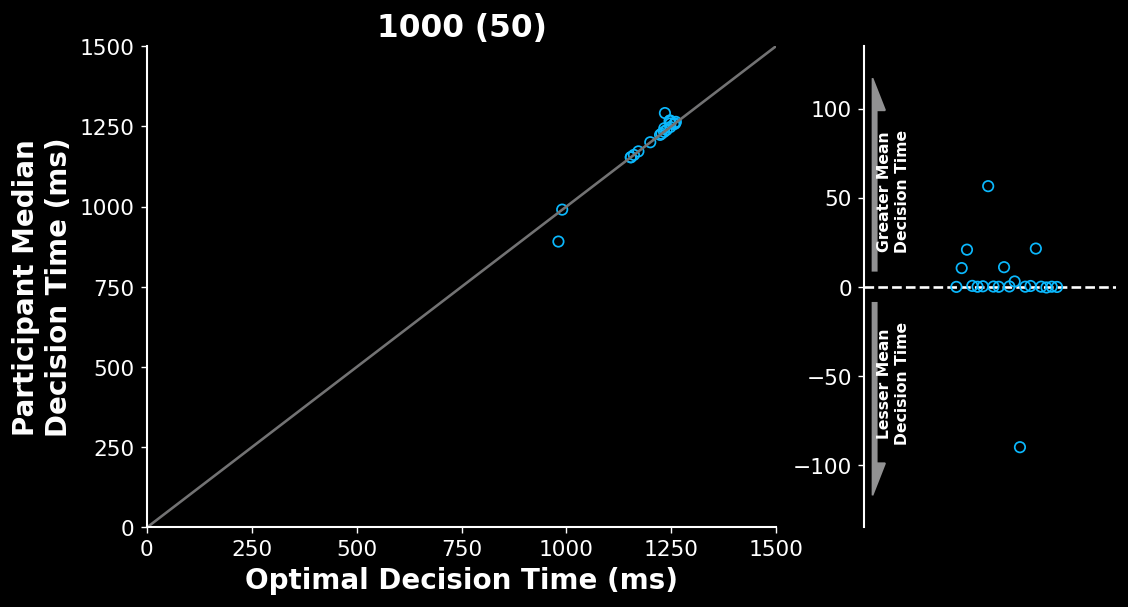

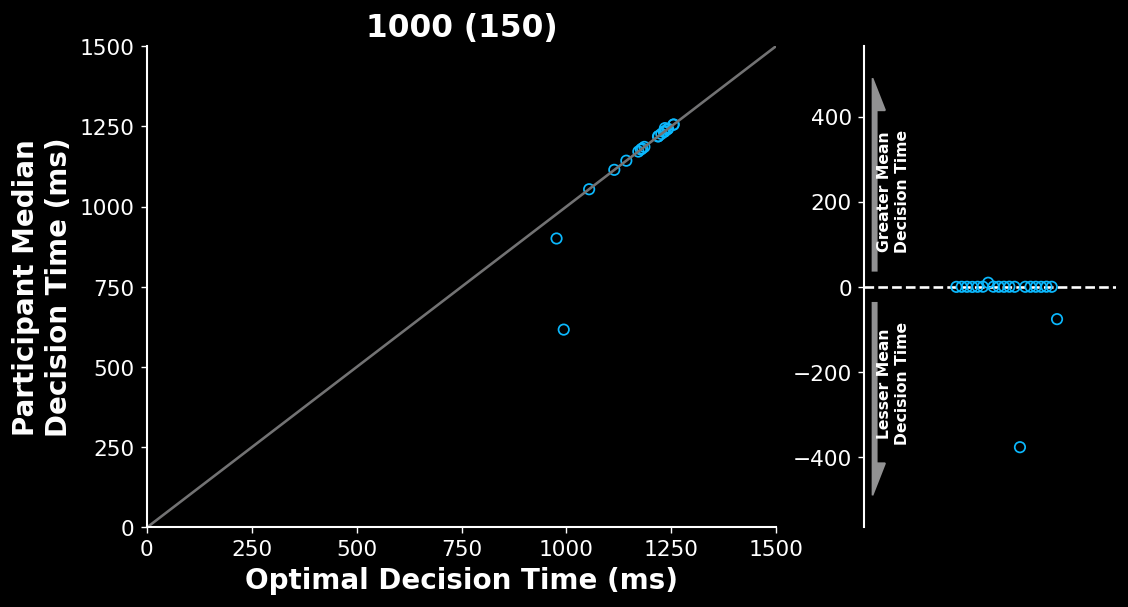

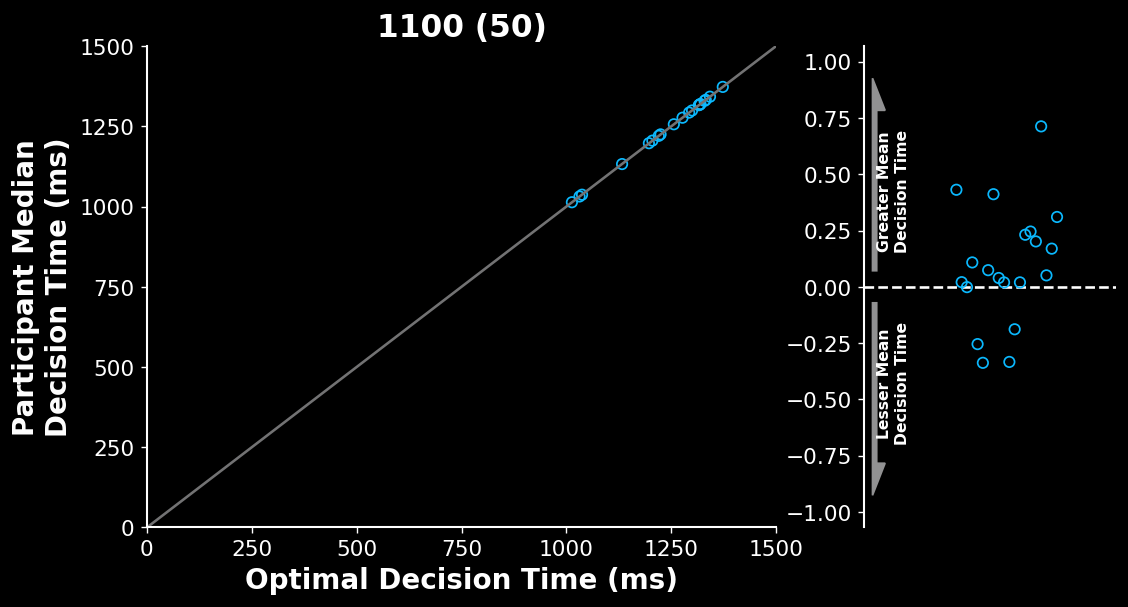

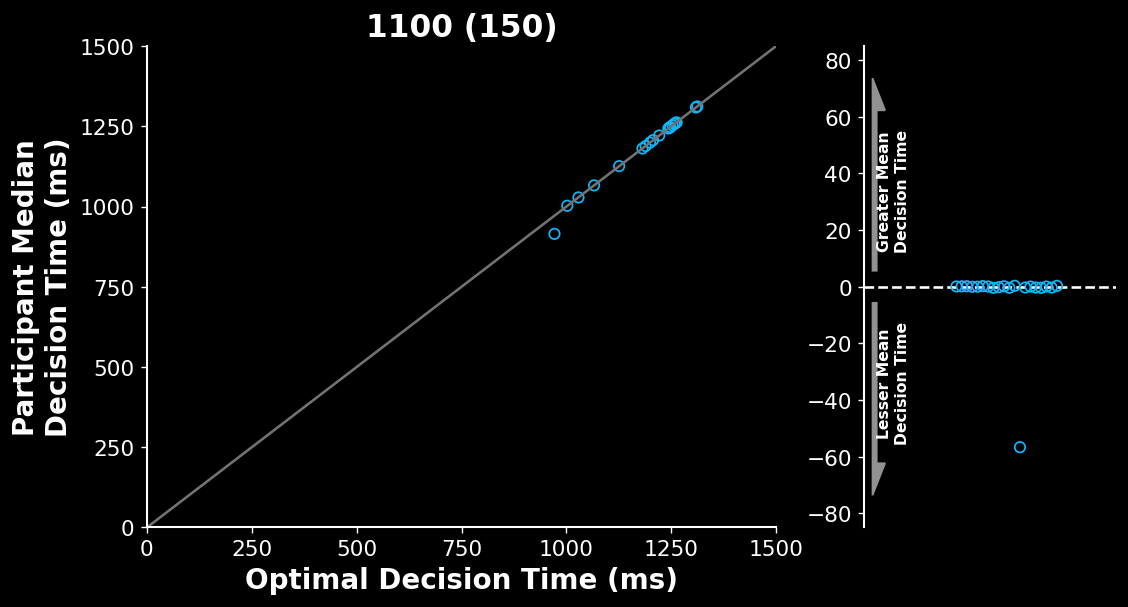

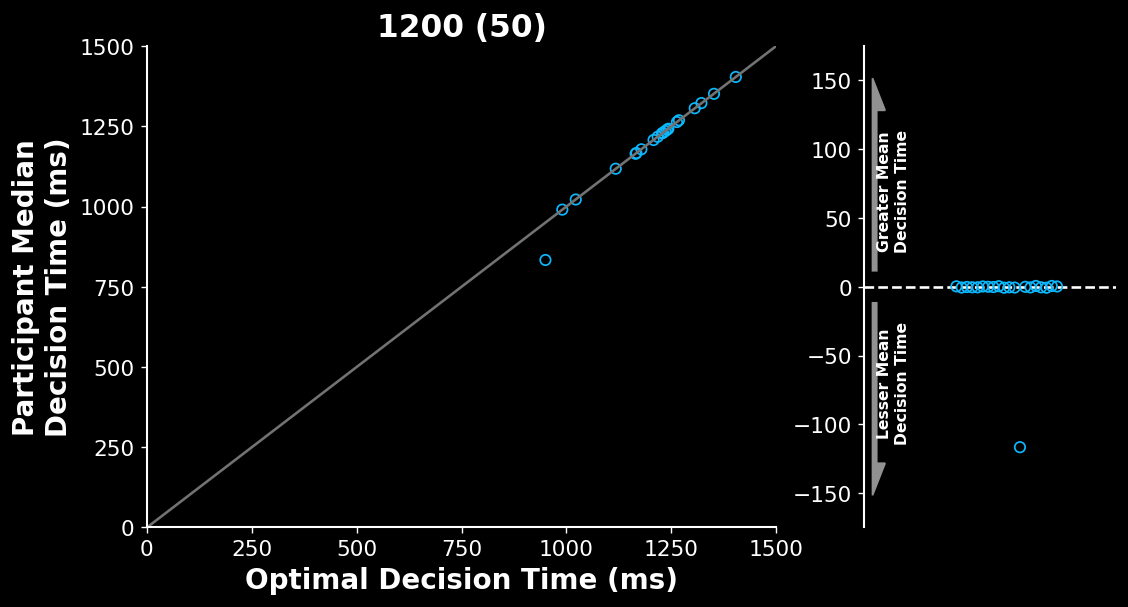

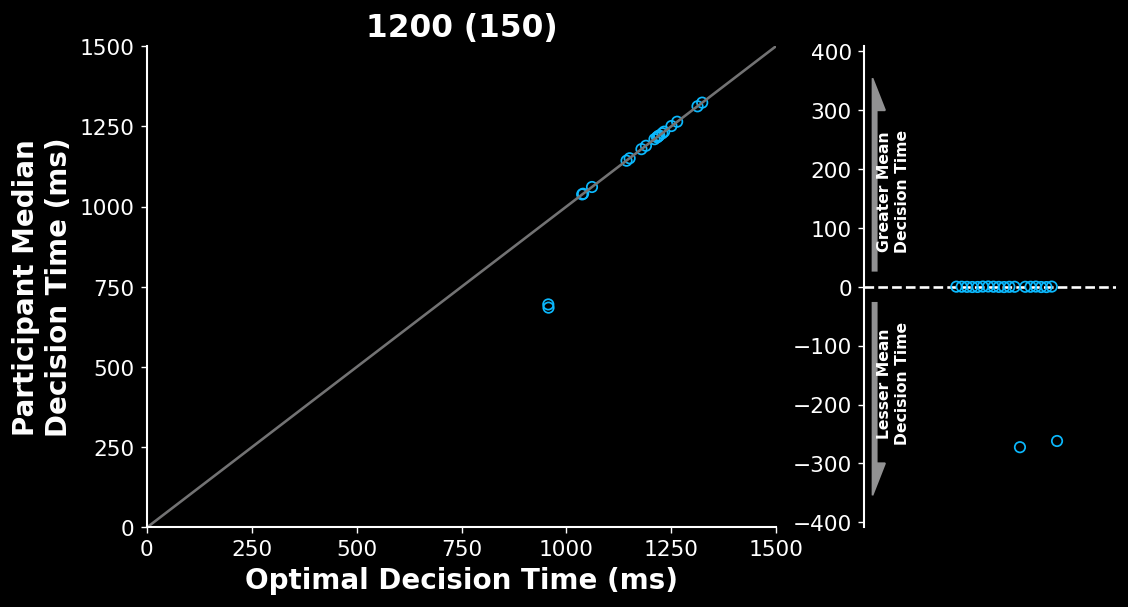

In [ ]:
data_metric = np.nanmedian(group.player_task_leave_time,axis=2) 
optimal_metric = grouped_model_tuned.wtd_optimal_leave_target_time
xlocs = np.arange(0,1750,250)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i],facecolors='none',edgecolors=wheel.rak_blue)
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(0,xlocs[-1])
    ax0.set_ylim(0,ylocs[-1])
    ax0.set_xlabel('Optimal Decision Time (ms)')
    ax0.set_ylabel('Participant Median\nDecision Time (ms)')
    ax0.set_title(f'{trial_block_titles[i]}')
    ax0.set_xticks(xlocs)
    ax0.set_yticks(ylocs)

    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff,facecolors='none',edgecolors=wheel.rak_blue)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'Greater Mean\nDecision Time',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Lesser Mean\nDecision Time',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

Wins

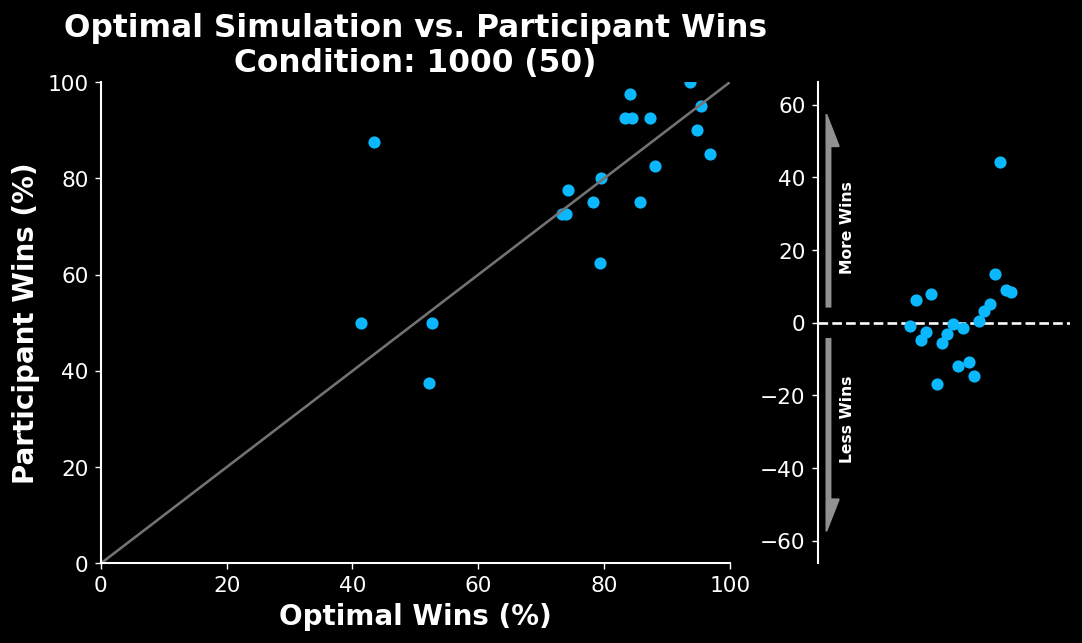

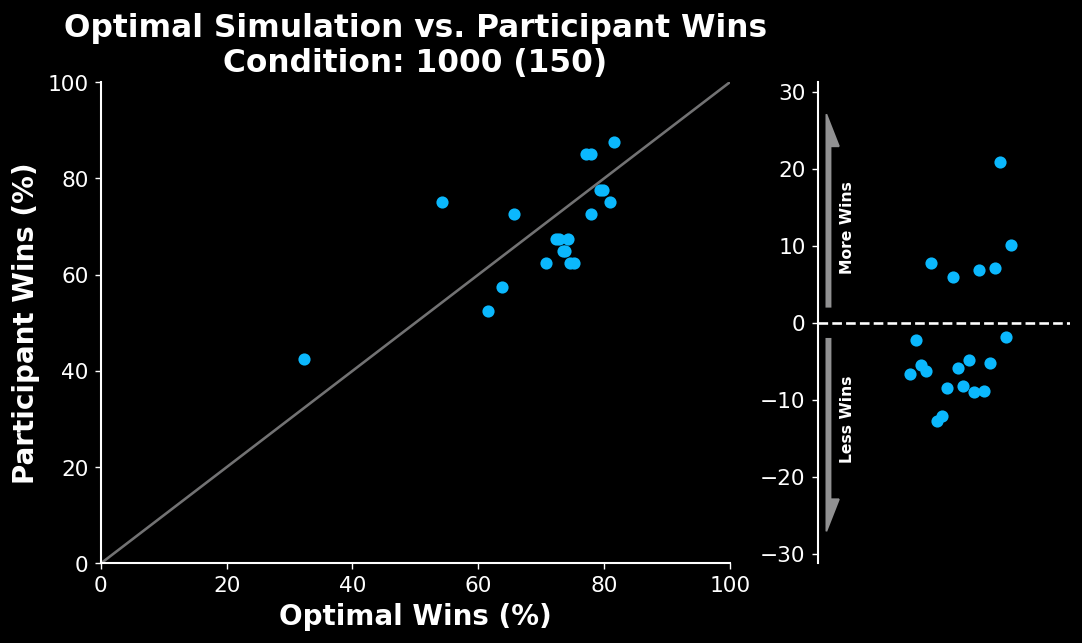

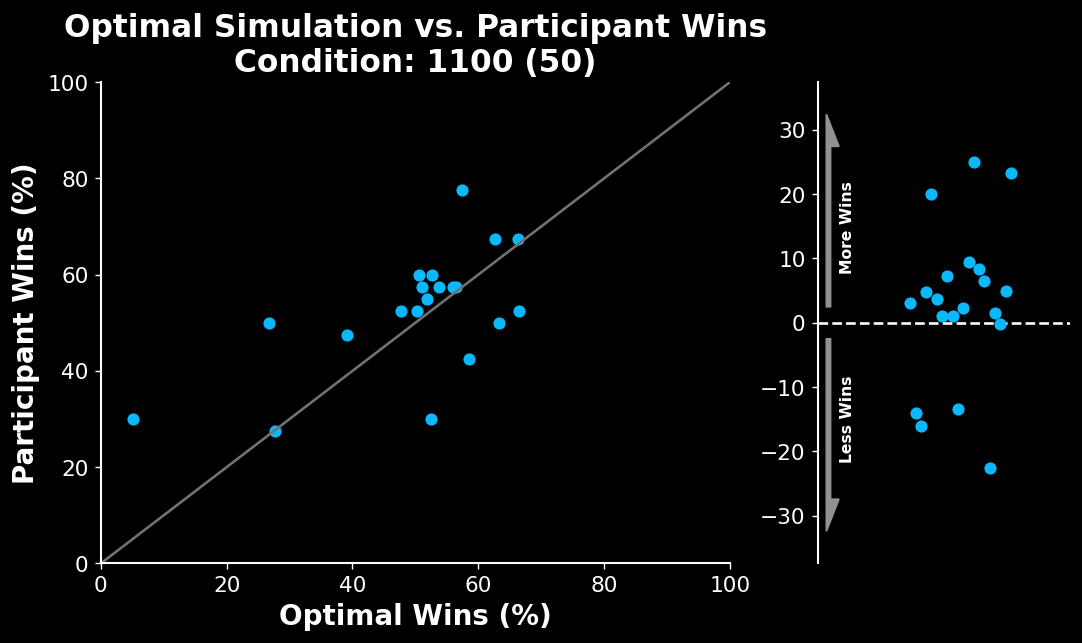

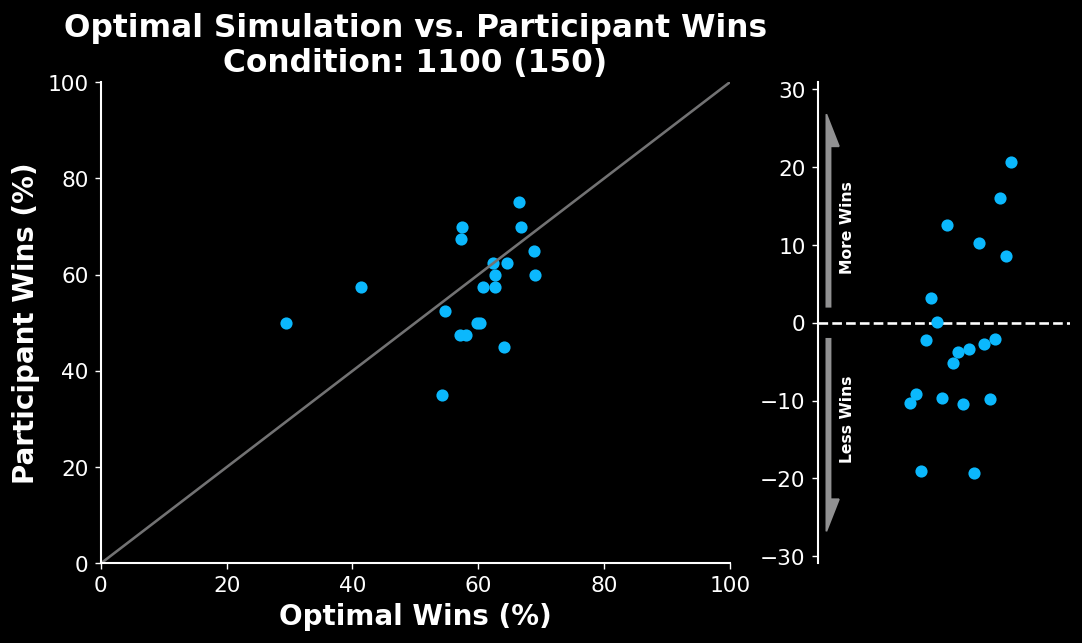

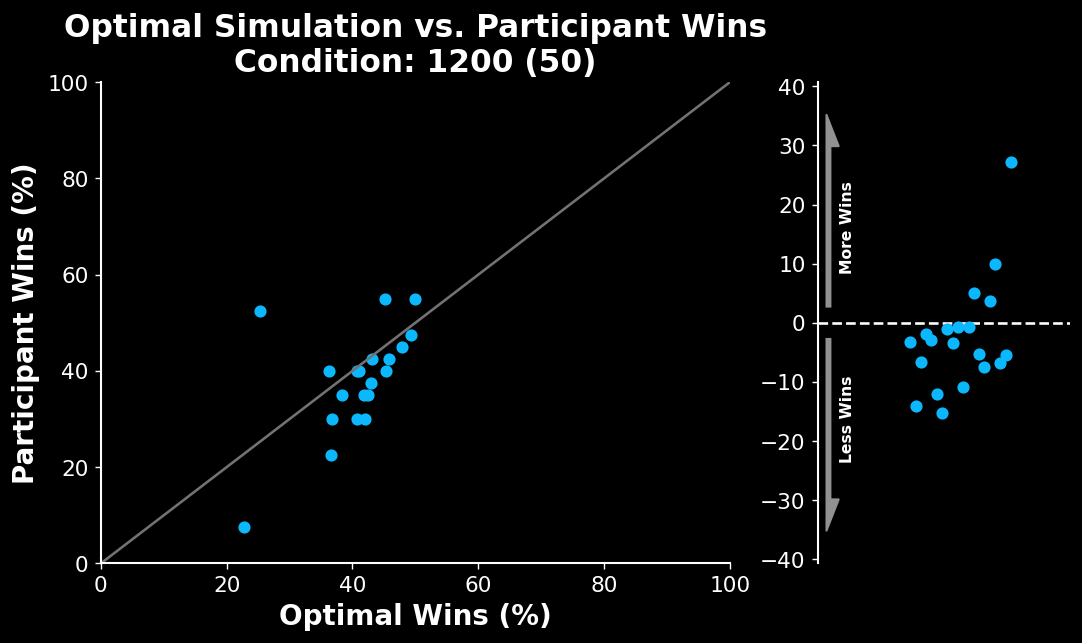

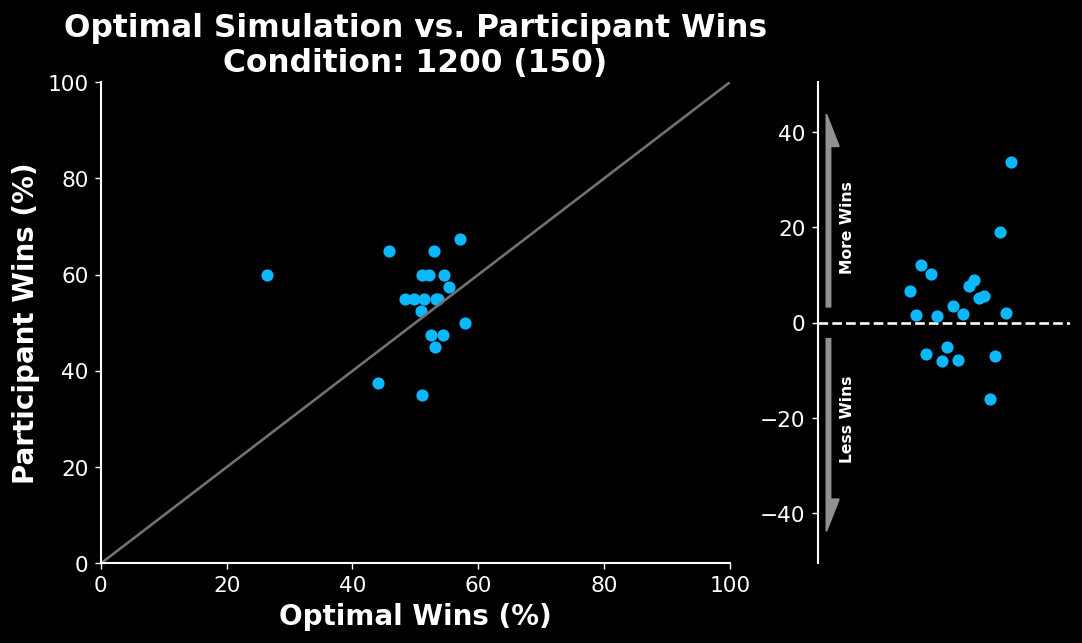

In [ ]:
data_metric = group.combine_all_subjects('player_perc_wins') 
optimal_metric = grouped_model_tuned.perc_win_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Wins (%)')
    ax0.set_ylabel('Participant Wins (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Wins\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Wins',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Wins',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

Indecisions

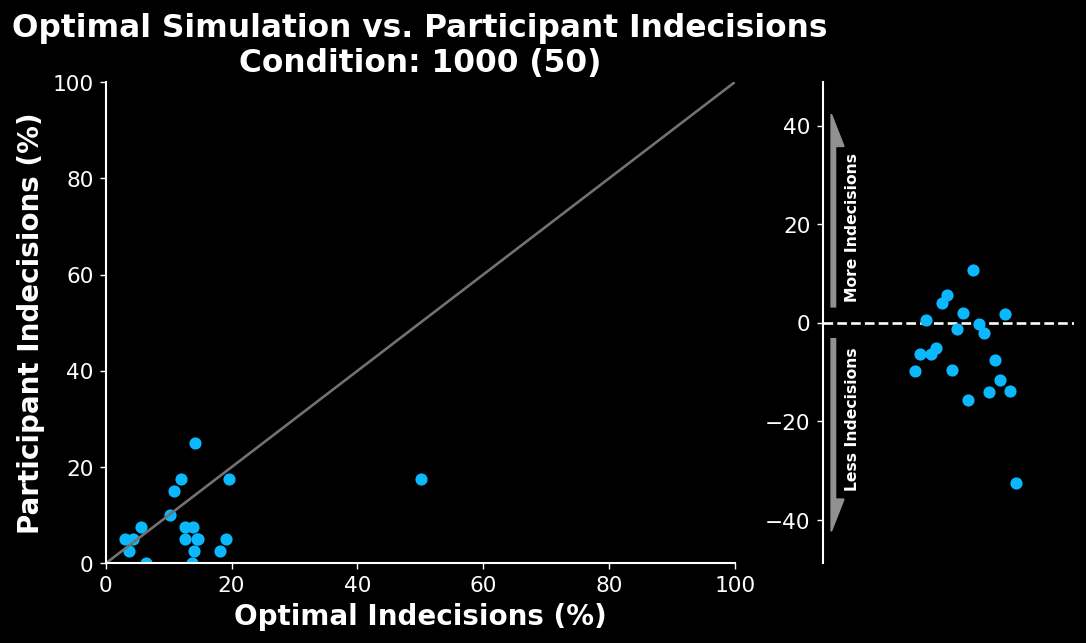

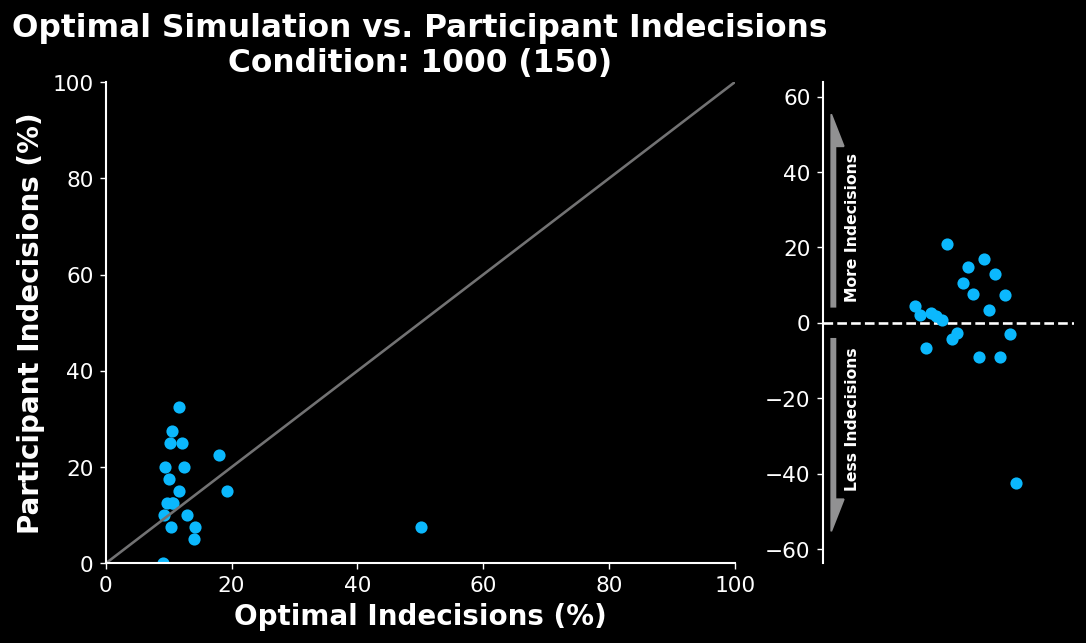

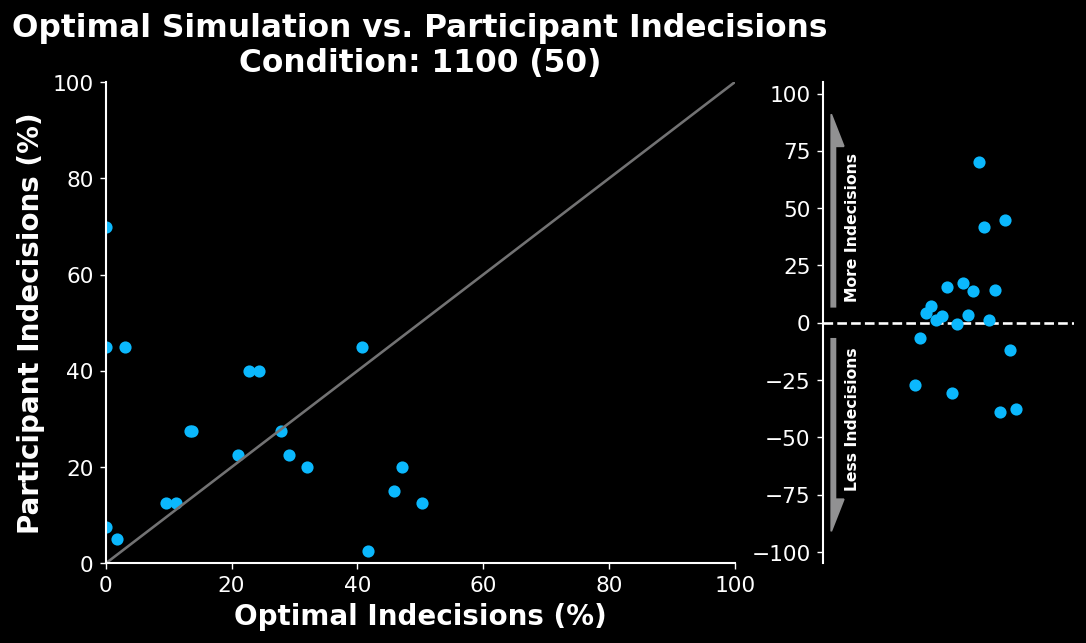

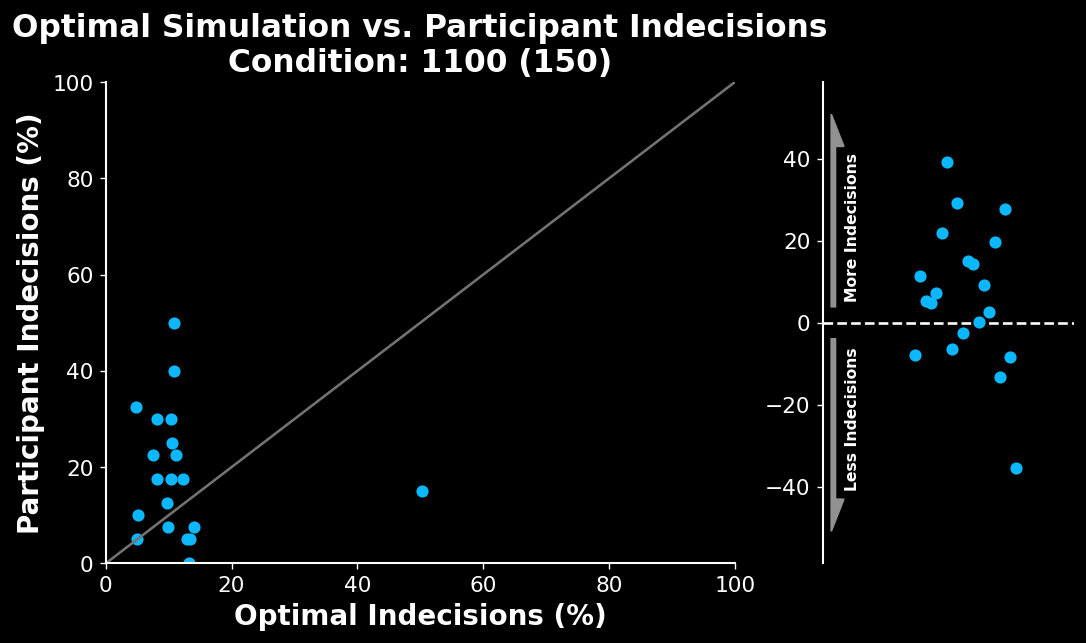

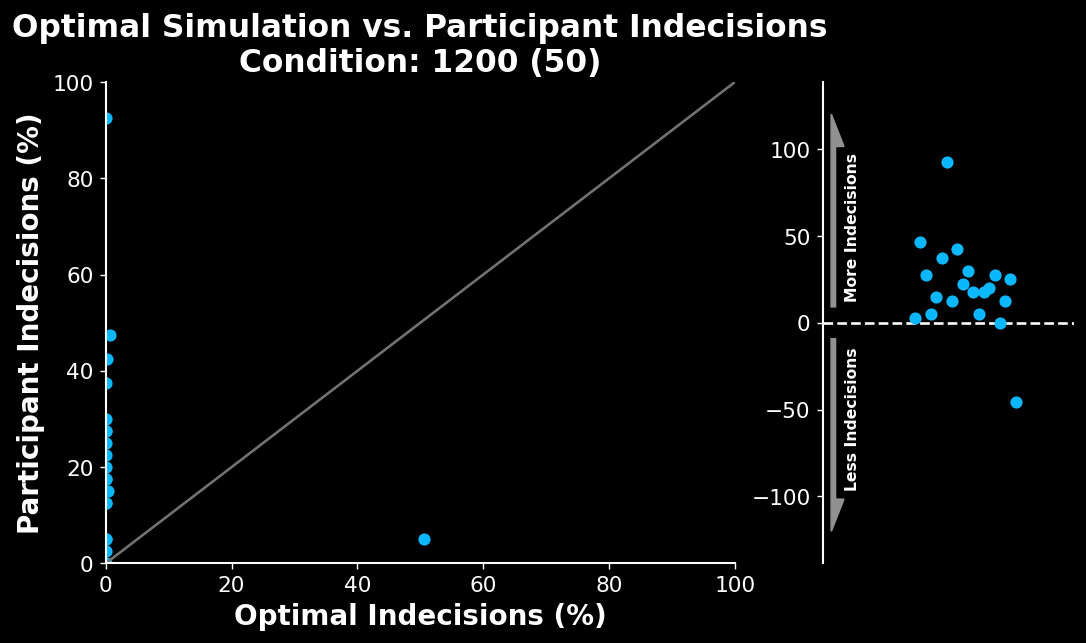

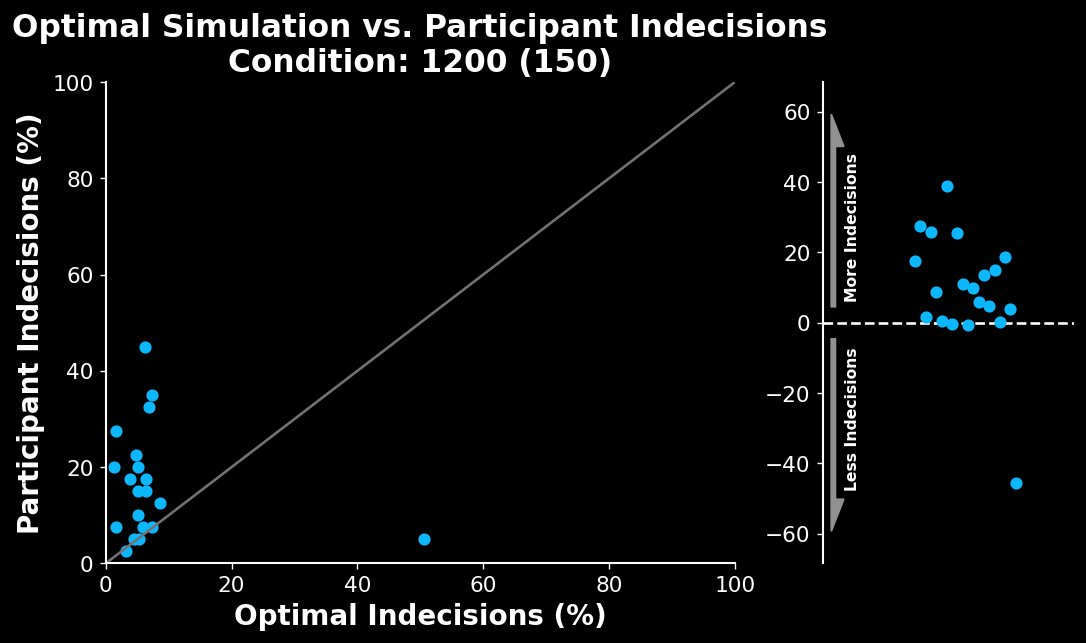

In [ ]:
data_metric = group.combine_all_subjects('player_perc_indecisions') 
optimal_metric = grouped.perc_indecision_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Indecisions (%)')
    ax0.set_ylabel('Participant Indecisions (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Indecisions\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Indecisions',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Indecisions',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)

Incorrects

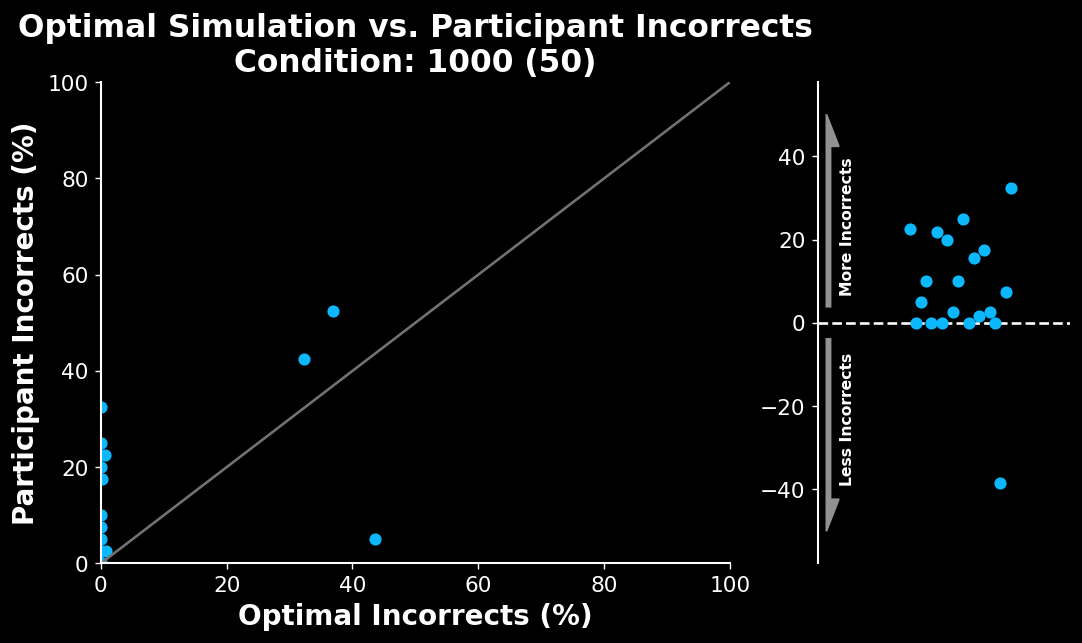

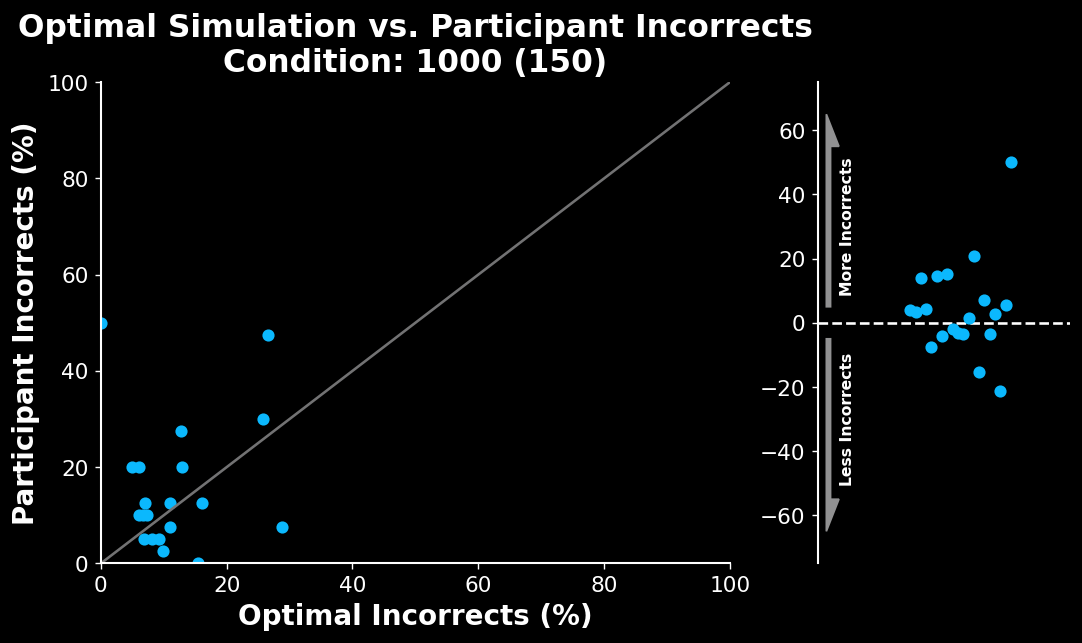

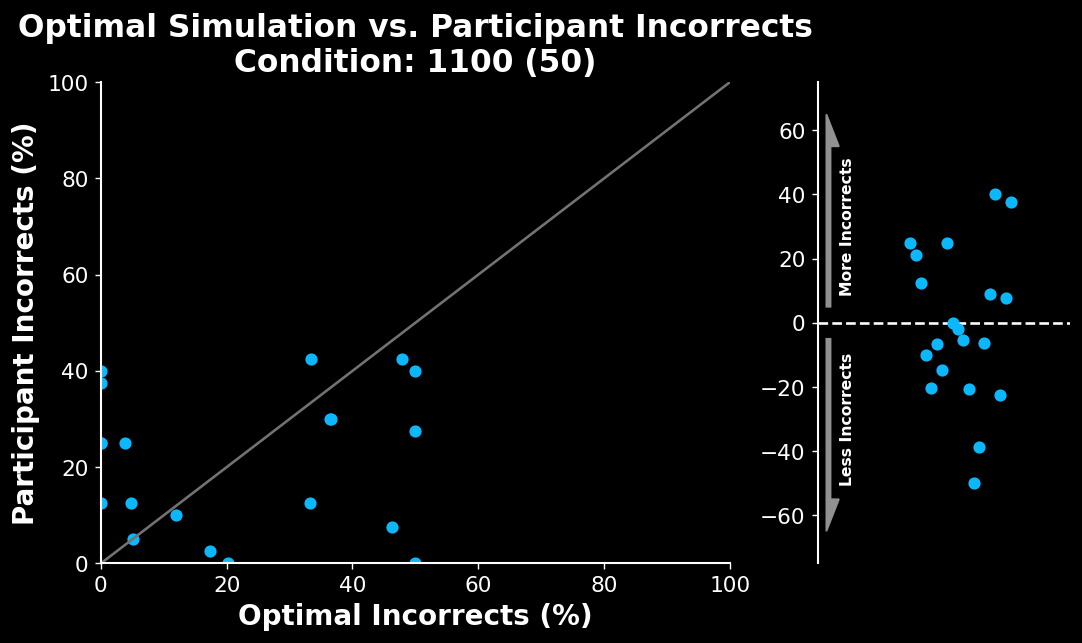

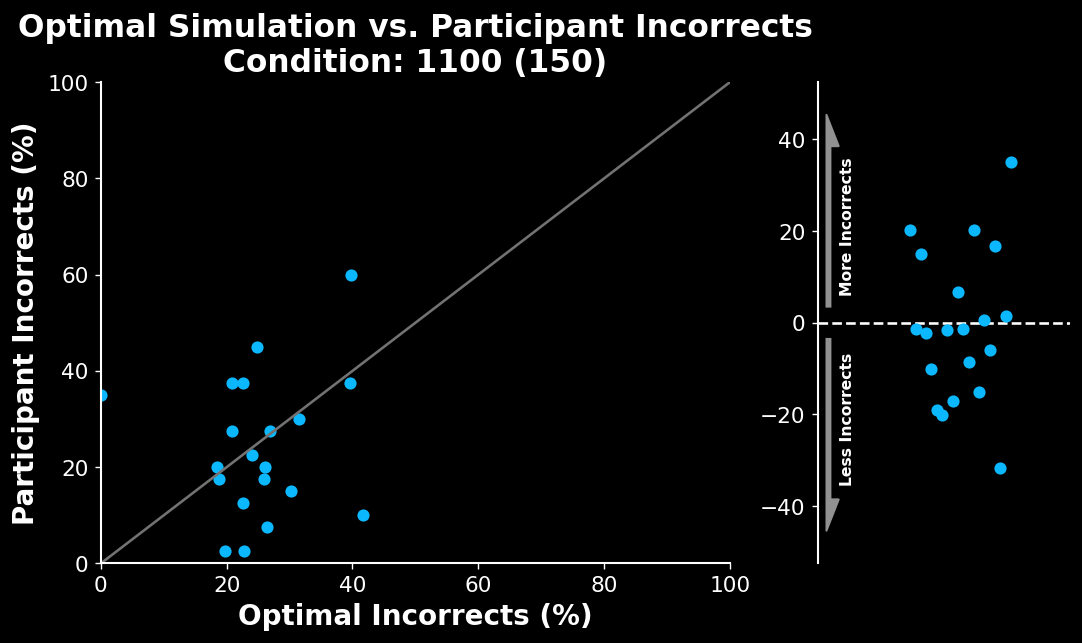

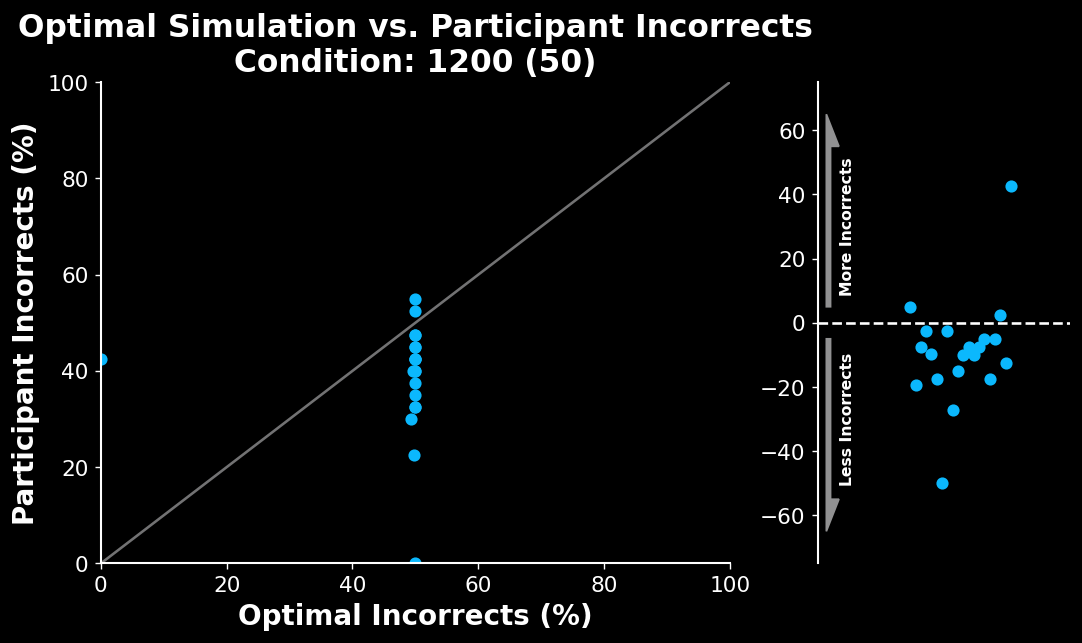

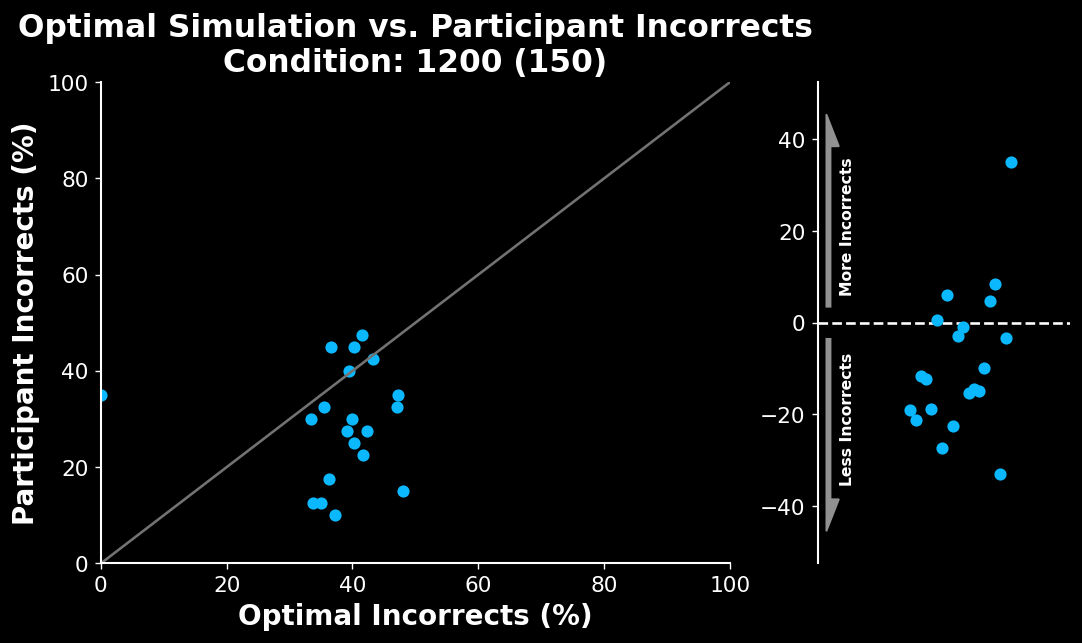

In [ ]:
data_metric = group.combine_all_subjects('player_perc_incorrects') 
optimal_metric = grouped.perc_incorrect_optimal_calc
xlocs = np.arange(0,125,25)
ylocs = xlocs
ax1_xlocs = np.linspace(0.25,0.85,num_subjects)
for i in range(num_blocks):
    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]},figsize = (10,5),dpi=125)   
    ax0.scatter(optimal_metric[:,i], data_metric[:,i])
    ax0.plot(xlocs,ylocs, color = wheel.dark_grey)
    ax0.set_xlim(xlocs[0],xlocs[-1])
    ax0.set_ylim(ylocs[0],ylocs[-1])
    ax0.set_xlabel('Optimal Incorrects (%)')
    ax0.set_ylabel('Participant Incorrects (%)')
    ax0.set_title(f'Optimal Simulation vs. Participant Incorrects\nCondition: {trial_block_titles[i]}')
    
    
    diff = data_metric[:,i] - optimal_metric[:,i] 
    ax1.scatter(ax1_xlocs,diff)
    ax1.axhline(zorder=0,linestyle='--')
    max_diff = np.max(abs(diff))

    arrow_length = max_diff 
    head_length = 0.2*arrow_length
    arrow_x_init = -0.25
    arrow_y_init = max_diff/10
    
    text_y1 = arrow_length/2 + arrow_y_init
    text_y2 = -arrow_length/2 - arrow_y_init
    
    ax1.arrow(arrow_x_init,arrow_y_init,0, arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'left',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y1,'More Incorrects',rotation = 90, fontweight='bold',ha='center',va='center',fontsize=9)
    ax1.arrow(arrow_x_init,-arrow_y_init,0,-arrow_length, width = 0.05, length_includes_head = False, head_length = head_length,head_width=0.15,shape = 'right',color=wheel.grey)
    ax1.text(arrow_x_init/2,text_y2,'Less Incorrects',rotation = 90, fontweight='bold',ha='center',va='center',fontsize = 9)
    
    ax1.set_ylim(-max_diff-(1/2)*max_diff,max_diff+(1/2)*max_diff)
    ax1.set_xlim(-0.3,1.2)
    ax1.set_xticks([])
    ax1.spines.bottom.set_visible(False)